In [263]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

In [264]:
df_train1 = pd.read_csv("train.csv")
df_test1 = pd.read_csv("test.csv")
df_train1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [265]:
df_test1.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [266]:
df_train1.shape

(7613, 5)

In [267]:
df_test1.shape

(3263, 4)

In [268]:
# eksik veri kontrolü

print(df_train1.isnull().sum())
print("-----------")
print(df_test1.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
-----------
id             0
keyword       26
location    1105
text           0
dtype: int64


In [269]:
df_test = df_test1[["text"]]
df_train = df_train1[["text","target"]]

In [270]:
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [271]:
df_test.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [272]:
# train
# •	Büyük küçük harf dönüşümü
# •	Noktalama işaretlerin çıkarılması
# •	Numerik ifadelerin çıkarılması
import emoji
import re
def clean_text(text):
    # Normalizing Case Folding
    text = re.sub(r'(?s)(.*)', lambda x: x.group(0).lower(), text)
     #convert emoji into text representation
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove new lines
    text = re.sub(r'\n', '', text)
    # Numbers
    text = re.sub(r'\b\d+(,\d+)*(\.\d+)?\b', '', text)
    # Remove all non-alphanumeric and non-whitespace characters except letters
    text = re.sub(r'[^\w\s]|_', '', text)
   
    return text
for i in range(len(df_train["text"])):
    df_train["text"][i] = clean_text(df_train["text"][i])
df_train.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1


In [273]:
# test
# •	Büyük küçük harf dönüşümü
# •	Noktalama işaretlerin çıkarılması
# •	Numerik ifadelerin çıkarılması
import emoji
import re
def clean_text(text):
    # Normalizing Case Folding
    text = re.sub(r'(?s)(.*)', lambda x: x.group(0).lower(), text)
    #convert emoji into text representation
    text = emoji.demojize(text, delimiters=(" ", " "))  
    # Punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove new lines
    text = re.sub(r'\n', '', text)
    # Numbers
    text = re.sub(r'\b\d+(,\d+)*(\.\d+)?\b', '', text)
    # Remove all non-alphanumeric and non-whitespace characters except letters
    text = re.sub(r'[^\w\s]|_', '', text)
   
    return text
for i in range(len(df_test["text"])):
    df_test["text"][i] = clean_text(df_test["text"][i])
df_test.head()

,text
0,just happened a terrible car crash
1,heard about earthquake is different cities sta...
2,there is a forest fire at spot pond geese are ...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills in china and taiwan


In [274]:
# train
# Metin içinde öznitelik çıkarımı yaparken önemli olmayan kelimelerin çıkarılması

def remove_stopwords(text):
    stop_words = stopwords.words('English')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text
df_train["text"] = remove_stopwords(df_train["text"])

In [275]:
# text
# Metin içinde öznitelik çıkarımı yaparken önemli olmayan kelimelerin çıkarılması

def remove_stopwords(text):
    stop_words = stopwords.words('English')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text
df_test["text"] = remove_stopwords(df_test["text"])

In [276]:
from nltk.tokenize import word_tokenize

# Frekansı 1'den küçük olanları silme işlemi
sil_word = df_train['text'].apply(word_tokenize).explode().value_counts()

sil = sil_word[sil_word < 2]
df_train['text'] = df_train['text'].apply(lambda x: " ".join(w for w in x.split() if w not in sil))

In [277]:
# train
from nltk.tokenize import word_tokenize
# Frekansı 1'den küçük olanları silme işlemi
sil_word = df_train['text'].apply(word_tokenize).explode().value_counts()

sil = sil_word[sil_word < 2]
df_train['text'] = df_train['text'].apply(lambda x: " ".join(w for w in x.split() if w not in sil))


# test
sil_word = df_test['text'].apply(word_tokenize).explode().value_counts()

sil = sil_word[sil_word < 2]
df_test['text'] = df_test['text'].apply(lambda x: " ".join(w for w in x.split() if w not in sil))

In [278]:
# Metinleri tokenize edip sonuçları gözlemleyiniz.

df_train["text"].apply(lambda x: TextBlob(x).words)

0       [deeds, reason, earthquake, may, allah, forgiv...
1                        [forest, fire, near, la, canada]
2       [residents, asked, shelter, place, officers, e...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, alaska, smoke, wildfires, s...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610    [m194, utc5km, volcano, hawaii, httptcozdtoyd8...
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [279]:
# Lemmatization işlemini yapınız. (normalleştirme)

# test
df_test['text'] = df_test['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# train
df_train['text'] = df_train['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df_train.head()

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la canada,1
2,resident asked shelter place officer evacuatio...,1
3,people receive wildfire evacuation order calif...,1
4,got sent photo alaska smoke wildfire school,1


In [280]:
# Metindeki terimlerin frekanslarını hesaplayınız. (Barplot grafiği için gerekli)

tf = df_train["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.head()


,index,0
0,deed,2.00
1,reason,30.00
2,earthquake,53.00
3,may,87.00
4,allah,8.00


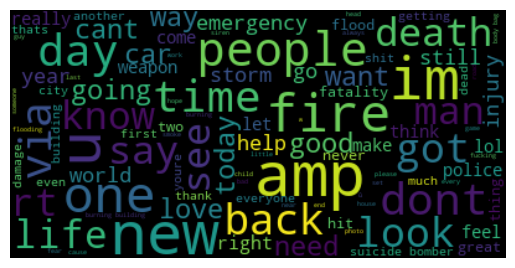

In [281]:
# Kelimeleri WordCloud ile görselleştiriniz.

# kelimeleri birleştirdik
text = " ".join(i for i in df_train["text"])
# wordcloud görselleştirmenin özelliklerini belirliyoruz
wordcloud = WordCloud(max_font_size=50,
max_words=100,
background_color="black").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Makine öğrenmesine hazırlık!

In [282]:
# Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olara ayırınız.
# Test-Train
x_train, x_test, y_train, y_test = train_test_split(df_train["text"],df_train["target"], test_size = 0.20,random_state=42,shuffle=True,stratify = df_train['target'])

In [283]:
# Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte.

# CountVectorizer kullanarak
count_vec = CountVectorizer()
x_train = count_vec.fit_transform(x_train)
x_test = count_vec.transform(x_test)

In [284]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# accuracy:
models = [
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ("AdaBoost", AdaBoostClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ("XGBoost", XGBClassifier(objective='binary:logistic')),
          ("CatBoost", CatBoostClassifier(verbose=False)),
          ]
accuracy_list = []
for name, clf in models:
    cvs = cross_val_score(clf, 
                          x_test, y_test,
                          cv=5,
                          scoring="accuracy", n_jobs=-1)   
    print("Accuracy-->", cvs.mean(), name)   
    accuracy_list.append(cvs.mean())
    accuracy_list.append(name)

Accuracy--> 0.6323360655737705 KNN
Accuracy--> 0.7130823986194995 CART
Accuracy--> 0.7603515962036238 RF
Accuracy--> 0.7176617773943054 AdaBoost
Accuracy--> 0.7222778257118205 GBM
Accuracy--> 0.7393248490077653 XGBoost
Accuracy--> 0.7386842105263158 CatBoost


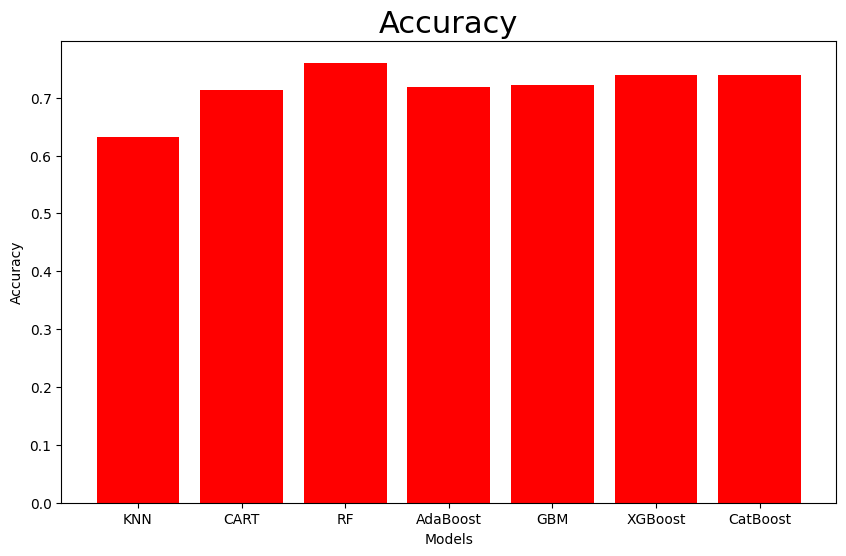

In [285]:
models = accuracy_list[1::2]
Accuracy = accuracy_list[::2]

plt.figure(figsize=(10, 6))
plt.bar(models, Accuracy, color="red")
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy', fontsize=22)
plt.show()

In [248]:
# RandomForestClassifier

import optuna
import pandas as pd
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
filterwarnings('ignore')
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = {}
best_accuracy_score = 0

def objective(trial, x_train, y_train):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    'max_depth': trial.suggest_int('max_depth', 1, 32),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])}

    model = RandomForestClassifier(**params, verbose=0)
    y_pred = cross_val_predict(model, x_train, y_train, cv=cv)
    accuracy = accuracy_score(y_train, y_pred)
    global best_accuracy_score, best_params
    if accuracy > best_accuracy_score:
        best_accuracy_score = accuracy
        best_params = params
    return 1 - accuracy
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, x_train, y_train), n_trials=50)
print("Best Accuracy Score:", best_accuracy_score)
print("Best Parameters:", best_params)

Best Accuracy Score: 0.7285714285714285
Best Parameters: {'n_estimators': 51, 'max_depth': 32, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [286]:
# modeli kurarak train dataları ile fit ediniz.
model = RandomForestClassifier(n_estimators=51,max_depth=32,min_samples_split=15,min_samples_leaf=1,max_features="sqrt") 
model_fit = model.fit(x_train, y_train)

In [287]:
# Test verilerini kullanarak tahmin yapın
y_pred = model_fit.predict(x_test)

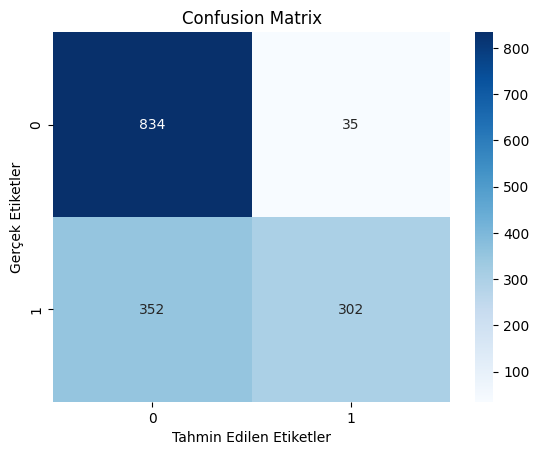

In [288]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiketler")
plt.ylabel("Gerçek Etiketler")
plt.show()

In [289]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
f1_Score = f1_score(y_test,y_pred)

print("precision:",precision)
print("recall:",recall)
print("accuracy:",accuracy)
print("f1_Score:",f1_Score)

precision: 0.8961424332344213
recall: 0.4617737003058104
accuracy: 0.7458962573867367
f1_Score: 0.6094853683148335


In [290]:
y_pred_train = model_fit.predict(x_train)

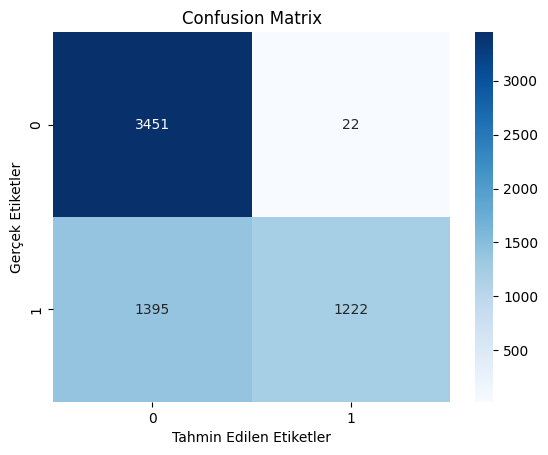

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiketler")
plt.ylabel("Gerçek Etiketler")
plt.show()

In [292]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

print("Train verisi")
precision = precision_score(y_train,y_pred_train)
recall = recall_score(y_train,y_pred_train)
accuracy = accuracy_score(y_train,y_pred_train)
f1_Score = f1_score(y_train,y_pred_train)

print("precision:",precision)
print("recall:",recall)
print("accuracy:",accuracy)
print("f1_Score:",f1_Score)

print("\n")

print("Test verisi")
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
f1_Score = f1_score(y_test,y_pred)

print("precision:",precision)
print("recall:",recall)
print("accuracy:",accuracy)
print("f1_Score:",f1_Score)

Train verisi
precision: 0.9823151125401929
recall: 0.4669468857470386
accuracy: 0.7673234811165845
f1_Score: 0.632996632996633


Test verisi
precision: 0.8961424332344213
recall: 0.4617737003058104
accuracy: 0.7458962573867367
f1_Score: 0.6094853683148335


unseen

In [293]:
df_test.head()

,text
0,happened terrible car crash
1,heard earthquake different city stay safe ever...
2,forest fire spot pond across street cannot save
3,apocalypse lighting wildfire
4,typhoon soudelor kill china taiwan


In [294]:
# Metin verilerini içeren "text" sütununu seçin
corpus = df_test["text"]
# TfidfVectorizer'ı metin verilerine uygulayarak dönüştürün
unseen = count_vec.transform(corpus)

In [295]:
# Test verilerini kullanarak tahmin yapın
unseen_pred = model_fit.predict(unseen)

In [296]:
df_test1["target"] = unseen_pred
df_test1.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [297]:
submission = df_test1[["id","target"]]

In [298]:
# Temizlenmiş veriyi CSV dosyasına kaydetmek

submission.to_csv('submission1.csv', index=False)